1. Data Preparation

In [1]:
# to make random processes reproducible
import random
import numpy as np
import tensorflow as tf

def set_seed(seed=42):
    random.seed(seed)            # Python random
    np.random.seed(seed)         # NumPy
    tf.random.set_seed(seed)     # TensorFlow

set_seed()

2025-08-17 17:01:03.157846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755450063.314012      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755450063.359031      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# load the data and split it to train and validation
from tensorflow.keras.preprocessing import image_dataset_from_directory

directory = 'ASL_Alphabet_Dataset/asl_alphabet_train'

image_size = 64
batch_size = 32

train_ds = image_dataset_from_directory(
    directory,            # path to directory
    labels='inferred',    # infer labels from folder names
    label_mode='int',     # labels are integers (0, 1, 2…)
    class_names=None,     # class names inferred from folder names (alphabetical)
    color_mode='rgb',     # 3 color channels
    batch_size=batch_size,# Number of images per batch
    image_size=image_size,# Resize images to this size (width, height)
    validation_split=0.2, # 0.2 for 20% validation split
    subset="training",    # "training" or "validation" → used with validation_split
    shuffle=True,         # randomize the order of images
    seed=42               # Random seed (to make results reproducible)
)

temp_ds = image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    seed=42
)

temp_size = tf.data.experimental.cardinality(temp_ds).numpy()
valid_size = temp_size // 2

valid_ds = temp_ds.take(valid_size)
test_ds  = temp_ds.skip(valid_size)

Found 223074 files belonging to 29 classes.
Using 178460 files for training.


I0000 00:00:1755450208.732352      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 223074 files belonging to 29 classes.
Using 44614 files for validation.


In [3]:
class_names = train_ds.class_names
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [4]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
# makes data loading run in parallel with model training,
# so the next batch is prepared while the current one is being processed,
# speeding up training.
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
# take one batch from the dataset (one batch has 32 images )
for image_batch, label_batch in train_ds.take(1):
    print(f"Batch Shape {image_batch.shape}")
    print(f"Image Shape {image_batch[0].shape}")
    print(f"Label Shape {label_batch[0].shape}")

Batch Shape (32, 64, 64, 3)
Image Shape (64, 64, 3)
Label Shape ()


In [7]:
# first image 
image_batch[0]

<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[  1.6132812,   0.4296875, 222.01172  ],
        [ 17.296875 ,  12.9375   , 177.58984  ],
        [ 16.71875  ,  14.9140625, 179.27734  ],
        ...,
        [ 13.546875 ,   7.2773438, 182.16797  ],
        [ 10.6484375,  10.011719 , 178.97266  ],
        [ 12.707031 ,  10.59375  , 210.8086   ]],

       [[ 12.347656 ,   8.296875 , 174.29688  ],
        [124.609375 , 105.69141  ,  73.72656  ],
        [136.57422  , 110.94531  ,  81.89453  ],
        ...,
        [ 87.57422  ,  67.64453  ,  48.70703  ],
        [118.921875 , 107.984375 ,  97.22656  ],
        [ 96.46094  ,  95.63672  , 166.22266  ]],

       [[ 18.859375 ,  15.546875 , 177.1211   ],
        [135.33984  , 109.53516  ,  77.28906  ],
        [126.21484  ,  99.38281  ,  67.19531  ],
        ...,
        [120.61719  , 108.734375 ,  96.296875 ],
        [107.91797  , 105.109375 ,  93.90625  ],
        [100.20703  ,  97.328125 , 175.23047  ]],

       ...,

       

In [8]:
# first label
label_batch[0]

<tf.Tensor: shape=(), dtype=int32, numpy=1>

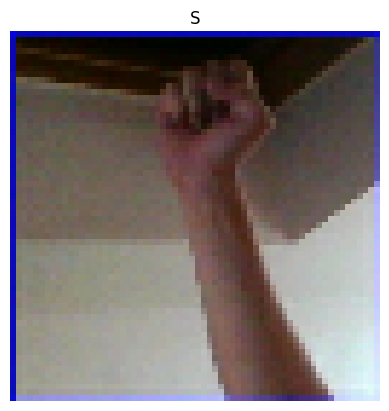

In [9]:
import matplotlib.pyplot as plt

def plot_image(img,label):
    img = tf.reshape(img, (image_size,image_size, 3))
    img = tf.cast(img, dtype=tf.uint8) # because imshow() need integer values (unsigned int 8 => [0, 256-1])
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')
    plt.show()

image_index = 2
plot_image(image_batch[image_index],label_batch[image_index])

## Manual Preprocessing

In [10]:
# Scale the image by divide it by 255 (Normalization)
train_ds_scaled = train_ds.map(lambda x, y: (x/255.0, y))
valid_ds_scaled   = valid_ds.map(lambda x, y: (x/255.0, y))
test_ds_scaled   = test_ds.map(lambda x, y: (x/255.0, y))

In [11]:
for image,label in train_ds_scaled.take(1):
    print(image.shape)
    print(label.shape) # pixel=0 (black)

(32, 64, 64, 3)
(32,)


In [12]:
# values be a float numbers from 0 ---> 1
image[0]

<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[0.00450368, 0.00185355, 0.87832415],
        [0.05073529, 0.04901961, 0.7299479 ],
        [0.05916054, 0.04704351, 0.7301011 ],
        ...,
        [0.05755208, 0.0439951 , 0.71223956],
        [0.04546569, 0.03253676, 0.7193321 ],
        [0.04257046, 0.04289216, 0.8290288 ]],

       [[0.09722733, 0.06968444, 0.74684435],
        [0.6433364 , 0.58045346, 0.5185509 ],
        [0.64024204, 0.57824755, 0.49342832],
        ...,
        [0.51675856, 0.44027266, 0.37849265],
        [0.44488358, 0.36498162, 0.32184437],
        [0.3498468 , 0.297549  , 0.58244485]],

       [[0.03878677, 0.05176164, 0.72987133],
        [0.446875  , 0.4324142 , 0.39566484],
        [0.5606618 , 0.5627298 , 0.5213388 ],
        ...,
        [0.51121324, 0.43357843, 0.3547641 ],
        [0.527405  , 0.44307598, 0.35923713],
        [0.47489277, 0.4231771 , 0.6972273 ]],

       ...,

       [[0.03439032, 0.04632353, 0.7259804 ],
        [0.2909

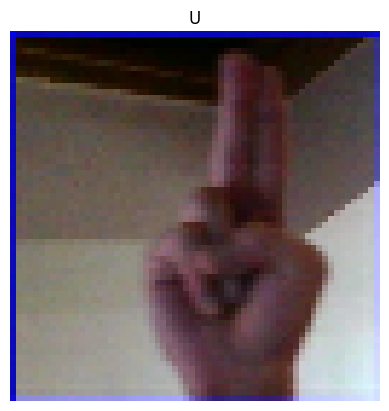

In [13]:
def plot_image(img,label,scaled=False):
    img = tf.reshape(img, (image_size, image_size, 3))
    if not scaled: # because scaled data (0 ---> 1) float values can be accepted in imshow()
        img = tf.cast(img, dtype=tf.uint8)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')
    plt.show()

image_index = 4
plot_image(image[image_index],label[image_index],scaled=True)

# Modeling
* a) Deep Neural Network (DNN)
* b) Convolutional Neural Network (CNN)

## a) Deep Neural Network (DNN)

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,Sequential

In [ ]:

#### input layers
input_ = Input(shape=(image_size,image_size,3))
scale_input = Rescaling(1/255.0)(input_) # make (255.0) float to avoid datatype mismatch
flatten_input = Flatten()(scale_input)

#### hidden layer 1
hidden = Dense(1000, kernel_initializer="he_normal")(flatten_input) # the best practice is (12288 ---> 64*64*3) but because it will take a high size i will set it (1000)
hidden = BatchNormalization()(hidden) # to avoid exploding/vanishing gradients
hidden = ReLU()(hidden) # activation function

#### hidden layer 2
hidden = Dense(1000, kernel_initializer="he_normal")(hidden) # use He Normal because it fits ReLU activations better
hidden = BatchNormalization()(hidden)
hidden = ReLU()(hidden)

#### hidden layer 3
hidden = Dense(700, kernel_initializer="he_normal")(hidden)
hidden = BatchNormalization()(hidden)
hidden = ReLU()(hidden)

#### output layer
output = Dense(29,activation='softmax',kernel_initializer="glorot_normal")(hidden)

model = Model(inputs=input_,outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │    12,289,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 700)            │       700,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 700)            │         2,800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │        20,329 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,021,829 (53.49 MB)

 Trainable params: 14,016,429 (53.47 MB)

 Non-trainable params: 5,400 (21.09 KB)

In [ ]:
# Compile the model
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [ ]:
# train the model
history = model.fit(train_ds,validation_data=valid_ds,epochs=40)

Epoch 1/40


I0000 00:00:1755450262.539952      65 service.cc:148] XLA service 0x7e5d0400fdd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755450262.541013      65 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755450262.918291      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


  10/5577 ━━━━━━━━━━━━━━━━━━━━ 1:54 21ms/step - accuracy: 0.0555 - loss: 3.9901

I0000 00:00:1755450264.195611      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5577/5577 ━━━━━━━━━━━━━━━━━━━━ 300s 53ms/step - accuracy: 0.5018 - loss: 1.6325 - val_accuracy: 0.6171 - val_loss: 1.3780
Epoch 2/40
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - accuracy: 0.8457 - loss: 0.4609 - val_accuracy: 0.7031 - val_loss: 1.1883
Epoch 3/40
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - accuracy: 0.9043 - loss: 0.2829 - val_accuracy: 0.7870 - val_loss: 0.8243
Epoch 4/40
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - accuracy: 0.9319 - loss: 0.2011 - val_accuracy: 0.7120 - val_loss: 1.5095
Epoch 5/40
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - accuracy: 0.9472 - loss: 0.1557 - val_accuracy: 0.8996 - val_loss: 0.3823
Epoch 6/40
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 85s 15ms/step - accuracy: 0.9548 - loss: 0.1318 - val_accuracy: 0.8150 - val_loss: 0.7556
Epoch 7/40
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 85s 15ms/step - accuracy: 0.9626 - loss: 0.1103 - val_accuracy: 0.8815 - val_loss: 0.5878
Epoch 8/40
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 86s 15ms/step - accuracy: 0.9675 - loss: 0.0

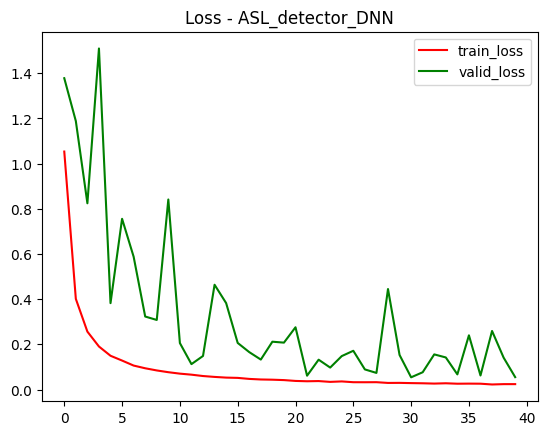

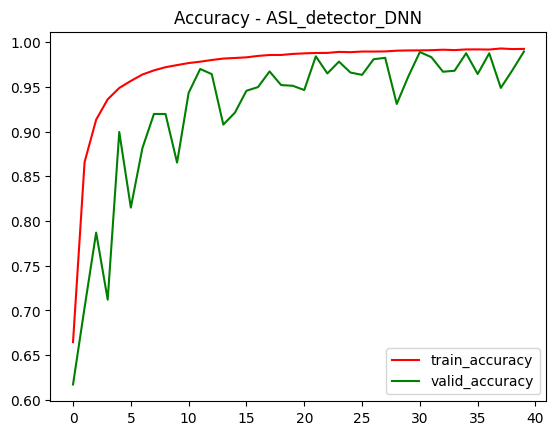

In [ ]:
def plot_loss_acc(history, model_name='model_1'):
    plt.title(f"Loss - {model_name}")
    plt.plot(history.history['loss'], c='red', label='train_loss')
    plt.plot(history.history['val_loss'], c='green', label='valid_loss')
    plt.legend()
    plt.show()

    plt.title(f"Accuracy - {model_name}")
    plt.plot(history.history['accuracy'], c='red', label='train_accuracy')
    plt.plot(history.history['val_accuracy'], c='green', label='valid_accuracy')
    plt.legend()
    plt.show()

plot_loss_acc(history, model_name='ASL_detector_DNN')

In [ ]:
# test performance
model.evaluate(test_ds)

698/698 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.9914 - loss: 0.0505


[0.048568736761808395, 0.9904527068138123]

In [ ]:
# load test images
import os 
folder = "/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_test"

test_images = []
test_labels = []

for filename in os.listdir(folder):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(folder, filename)

        # 1. Load image and resize
        img = tf.keras.utils.load_img(img_path, target_size=(image_size,image_size))
        img_array = tf.keras.utils.img_to_array(img)
        test_images.append(img_array)

        # 2. Label from filename (without extension)
        label = os.path.splitext(filename)[0]
        test_labels.append(label)

# Convert to tensors
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)   # shape: (29, 64, 64, 3)

print("Images shape:", test_images.shape)
print("Labels:", test_labels)

Images shape: (28, 64, 64, 3)
Labels: ['A_test', 'E_test', 'L_test', 'N_test', 'S_test', 'D_test', 'G_test', 'I_test', 'W_test', 'M_test', 'nothing_test', 'X_test', 'H_test', 'Q_test', 'C_test', 'T_test', 'P_test', 'V_test', 'Y_test', 'U_test', 'space_test', 'O_test', 'B_test', 'R_test', 'F_test', 'Z_test', 'J_test', 'K_test']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


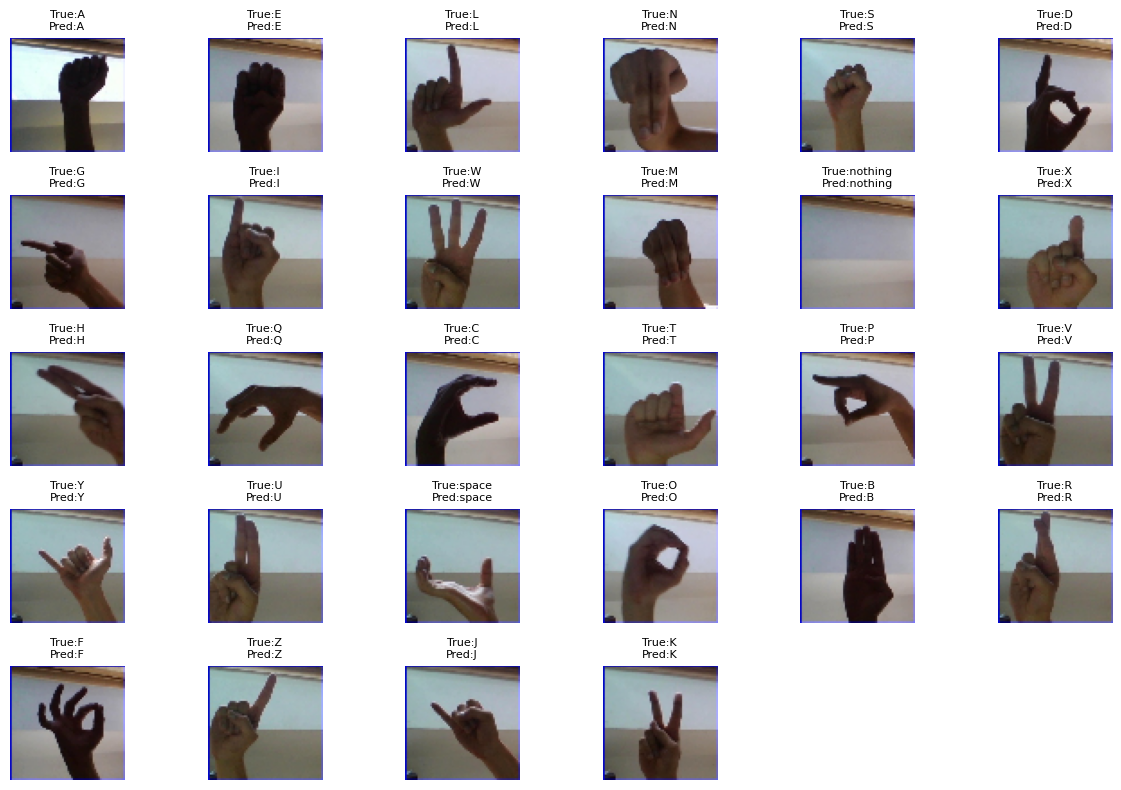

In [ ]:
pred_propas = model.predict(test_images)
pred_labels = pred_propas.argmax(axis=-1)

plt.figure(figsize=(12, 8))

for i in range(len(test_images)):
    plt.subplot(5, 6, i + 1)
    plt.imshow(test_images[i]/255.0)
    plt.axis("off")

    true_label = test_labels[i][:-5]
    plt.title(f"True:{true_label}\nPred:{class_names[pred_labels[i]]}", fontsize=8)

plt.tight_layout()
plt.show()

## b) Convolutional Neural Network (CNN)

In [ ]:
### Functional API [Better than Sequential because it's provide high control on layers workflow]

#### input layers
input_ = Input(shape=(image_size,image_size,3))
scale_input = Rescaling(1/255.0)(input_) # make (255.0) float to avoid datatype mismatch

#### convolutional layer 1 [best structer (conv-conv-maxpool) -> (conv-conv-maxpool) .... (dense) -> (output)]
hidden =Conv2D(64,kernel_size=3,padding='same',kernel_initializer="he_normal")(scale_input)
hidden = BatchNormalization()(hidden) # to avoid exploding/vanishing gradients
hidden = ReLU()(hidden) # activation function

hidden =Conv2D(64,kernel_size=3,padding='same',kernel_initializer="he_normal")(hidden)
hidden = BatchNormalization()(hidden) 
hidden = ReLU()(hidden) 

hidden = MaxPool2D()(hidden)

#### convolutional layer 2
hidden =Conv2D(128,kernel_size=3,padding='same',kernel_initializer="he_normal")(hidden)
hidden = BatchNormalization()(hidden)
hidden = ReLU()(hidden)

hidden =Conv2D(128,kernel_size=3,padding='same',kernel_initializer="he_normal")(hidden)
hidden = BatchNormalization()(hidden) 
hidden = ReLU()(hidden) 

hidden = MaxPool2D()(hidden)

#### convolutional layer 2
hidden =Conv2D(256,kernel_size=3,padding='same',kernel_initializer="he_normal")(hidden)
hidden = BatchNormalization()(hidden)
hidden = ReLU()(hidden)

hidden =Conv2D(256,kernel_size=3,padding='same',kernel_initializer="he_normal")(hidden)
hidden = BatchNormalization()(hidden) 
hidden = ReLU()(hidden) 

hidden = MaxPool2D()(hidden)

#### dense layer
hidden = Dense(700, kernel_initializer="he_normal")(hidden)
hidden = BatchNormalization()(hidden)
hidden = ReLU()(hidden)

hidden = Flatten()(hidden)
#### output layer
output = Dense(29,activation='softmax',kernel_initializer="glorot_normal")(hidden)

model2 = Model(inputs=input_,outputs=output)
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 16, 16, 256)    │             

 Total params: 2,630,921 (10.04 MB)

 Trainable params: 2,627,729 (10.02 MB)

 Non-trainable params: 3,192 (12.47 KB)

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model2.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [ ]:
# train the model
history2 = model2.fit(train_ds,validation_data=valid_ds,epochs=20)

Epoch 1/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 118s 19ms/step - accuracy: 0.6834 - loss: 1.5577 - val_accuracy: 0.9661 - val_loss: 0.1117
Epoch 2/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 101s 18ms/step - accuracy: 0.9738 - loss: 0.0890 - val_accuracy: 0.9713 - val_loss: 0.1000
Epoch 3/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 101s 18ms/step - accuracy: 0.9882 - loss: 0.0389 - val_accuracy: 0.8949 - val_loss: 0.3567
Epoch 4/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 101s 18ms/step - accuracy: 0.9925 - loss: 0.0251 - val_accuracy: 0.9885 - val_loss: 0.0372
Epoch 5/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 100s 18ms/step - accuracy: 0.9951 - loss: 0.0175 - val_accuracy: 0.9931 - val_loss: 0.0283
Epoch 6/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 101s 18ms/step - accuracy: 0.9959 - loss: 0.0146 - val_accuracy: 0.9942 - val_loss: 0.0191
Epoch 7/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 100s 18ms/step - accuracy: 0.9969 - loss: 0.0111 - val_accuracy: 0.9946 - val_loss: 0.0211
Epoch 8/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 103s 19ms/step - accuracy: 

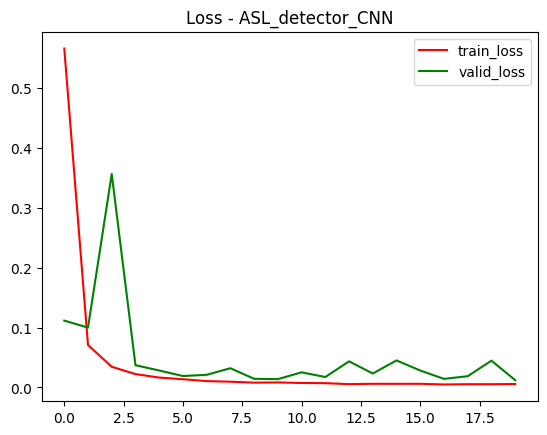

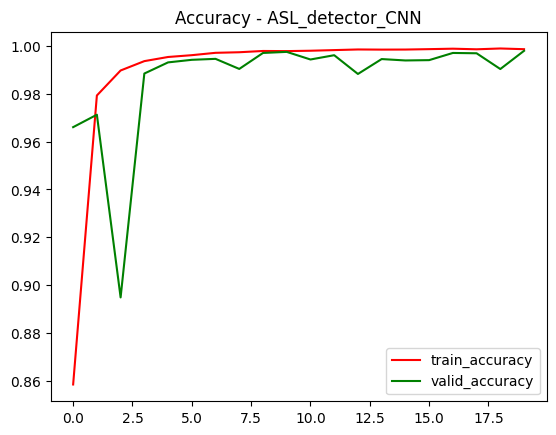

In [ ]:
plot_loss_acc(history2, model_name='ASL_detector_CNN')

In [ ]:
# test performance
model2.evaluate(test_ds)

698/698 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9973 - loss: 0.0131


[0.014375713653862476, 0.9976692199707031]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


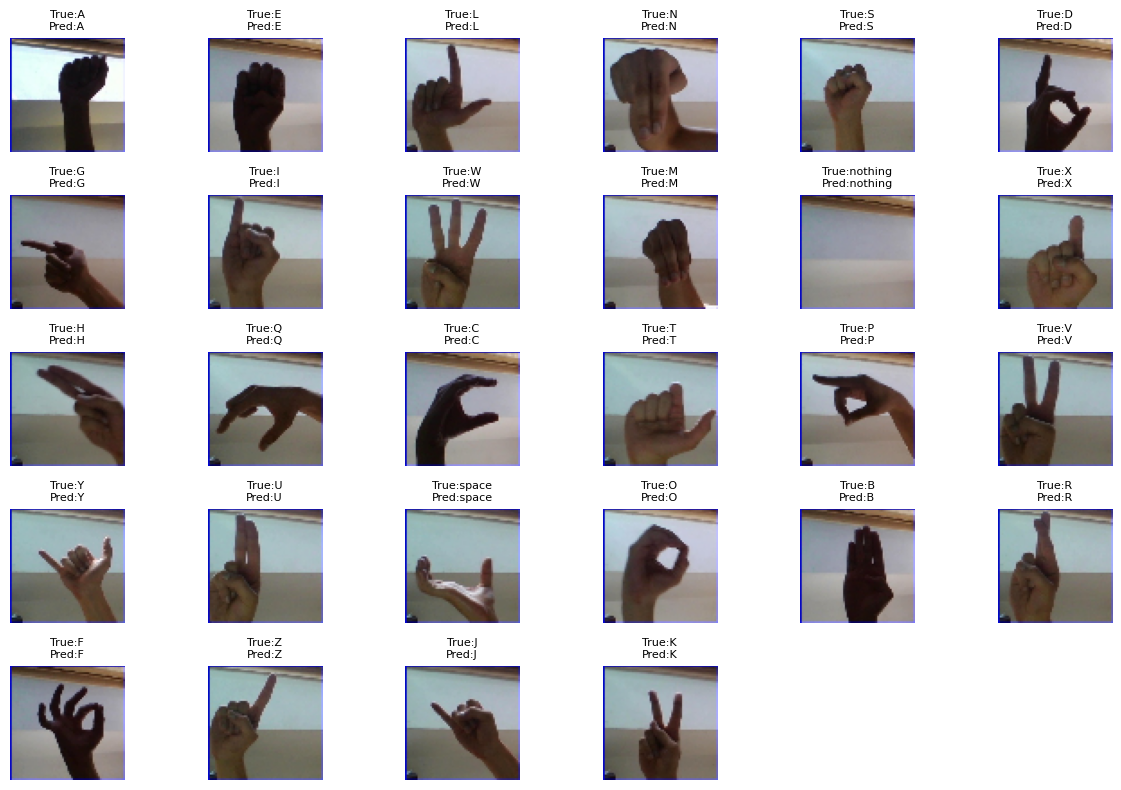

In [ ]:
pred_propas = model2.predict(test_images)
pred_labels = pred_propas.argmax(axis=-1)

plt.figure(figsize=(12, 8))

for i in range(len(test_images)):
    plt.subplot(5, 6, i + 1)
    plt.imshow(test_images[i]/255.0)
    plt.axis("off")

    true_label = test_labels[i][:-5]
    plt.title(f"True:{true_label}\nPred:{class_names[pred_labels[i]]}", fontsize=8)

plt.tight_layout()
plt.show()

## Save Model

In [ ]:
model2.save('ASL_detector_CNN.h5')

# load model
# model = tf.keras.models.load_model("ASL_detector_CNN.h5")